# Attention Mechanism Visualizer

This notebook implements and visualizes the attention mechanism that powers modern transformer models like GPT and BERT. This builds directly on the concepts covered in Andrej Karpathy's "Neural Networks: Zero to Hero" course, particularly the sections covering transformers and attention.

## What is Attention?

Attention is a mechanism that allows a model to focus on different parts of the input sequence when producing each element of the output. It's one of the key innovations that led to the transformer architecture and the current generation of large language models.

After reviewing this notebook, you will be able to:
1. Implement a clean, from-scratch version of self-attention
2. Visualize how attention heads focus on different parts of input sequences
3. Explore different attention patterns with customizable examples

## Setup and Imports

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.colors import LinearSegmentedColormap

# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# custom colormap
attention_colors = LinearSegmentedColormap.from_list(
    'attention_cmap', ['#f7fbff', '#6baed6', '#08519c']
)

## Implementing self-attention from scratch

We'll implement self-attention as described in the "Attention Is All You Need" paper and discussed in Karpathy's course. This implementation will be focused on clarity to make the mechanics transparent.

In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        """
        Self-attention layer with multiple heads.

        Args:
            d_model: Dimensionality of the input embeddings
            num_heads: Number of attention heads
        """
        super(SelfAttention, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        # d_model divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # linear projections
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def split_heads(self, x):
        """
        Split the last dimension into (num_heads, depth)
        and transpose to (batch_size, num_heads, seq_len, depth)
        """
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]

        x = tf.reshape(x, (batch_size, seq_len, self.num_heads, self.depth))

        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        """
        Calc attention weights and apply them to values.

        Returns:
            output: Weighted sum based on attention scores
            attention_weights: The attention weights used
        """
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        # scale attention scores
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # apply mask (if provided)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # apply softmax
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights

    def call(self, x, mask=None, return_attention=False):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]

        # linear projections
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        # split heads
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(
            q, k, v, mask
        )

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, seq_len, self.d_model))

        # final layer
        output = self.linear(concat_attention)

        if return_attention:
            return output, attention_weights

        return output

## Creating input data for visualization

To 'show' attention, we'll work with some sample sentences and visualize how the attention mechanism focuses on different words.

In [ ]:
def preprocess_sentence(sentence):
    return sentence.lower().split()

def create_simple_embeddings(tokens, embed_dim=64):
    # random embeddings for each token
    embeddings = np.random.normal(0, 1, (len(tokens), embed_dim))

    # let similar words have similar embeddings
    for i, token in enumerate(tokens):
        # (heuristic) first letter contributes 50% of the embedding pattern
        first_letter = ord(token[0]) - ord('a') if token and token[0].isalpha() else 0
        mask = np.ones(embed_dim)
        mask[:embed_dim//2] = first_letter / 26.0
        embeddings[i] *= mask

    return tf.convert_to_tensor(embeddings, dtype=tf.float32)

def prepare_input(sentence, embed_dim=64):
    """Prepare a sentence for attention visualization"""
    tokens = preprocess_sentence(sentence)
    embeddings = create_simple_embeddings(tokens, embed_dim)

    # batch dimension
    embeddings = tf.expand_dims(embeddings, 0)
    return tokens, embeddings

## Visualizing attention patterns

Now we'll create functions to visualize how attention weights distribute across tokens.

In [ ]:
def visualize_attention(tokens, attention_weights, head_index=0, title="Attention Weights"):
    """
    Visualize attention weights for a specific head.

    Args:
        tokens: List of input tokens
        attention_weights: Attention weights tensor with shape [batch, heads, seq_len, seq_len]
        head_index: Which attention head to visualize
        title: Title for the plot
    """
    attn = attention_weights[0, head_index].numpy()

    fig, ax = plt.subplots(figsize=(10, 8))

    sns.heatmap(attn,
                annot=True,
                cmap=attention_colors,
                fmt='.2f',
                xticklabels=tokens,
                yticklabels=tokens,
                ax=ax)

    ax.set_title(f"{title} (Head {head_index})")
    ax.set_ylabel("Query (from)")
    ax.set_xlabel("Key (to)")
    plt.tight_layout()
    plt.show()

def visualize_all_heads(tokens, attention_weights, ncols=2, title="Attention Heads"):
    """
    Visualize all attention heads in a grid.

    Args:
        tokens: List of input tokens
        attention_weights: Attention weights tensor with shape [batch, heads, seq_len, seq_len]
        ncols: Number of columns in the grid
        title: Title for the plot
    """
    num_heads = attention_weights.shape[1]
    nrows = math.ceil(num_heads / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))
    if nrows == 1 and ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i in range(num_heads):
        if i < num_heads:
            attn = attention_weights[0, i].numpy()
            sns.heatmap(attn,
                        annot=True,
                        cmap=attention_colors,
                        fmt='.2f',
                        xticklabels=tokens,
                        yticklabels=tokens,
                        ax=axes[i])
            axes[i].set_title(f"Head {i}")
        else:
            axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

## Exploring self-attention patterns

Let's create an attention model and visualize how it processes different input sentences.

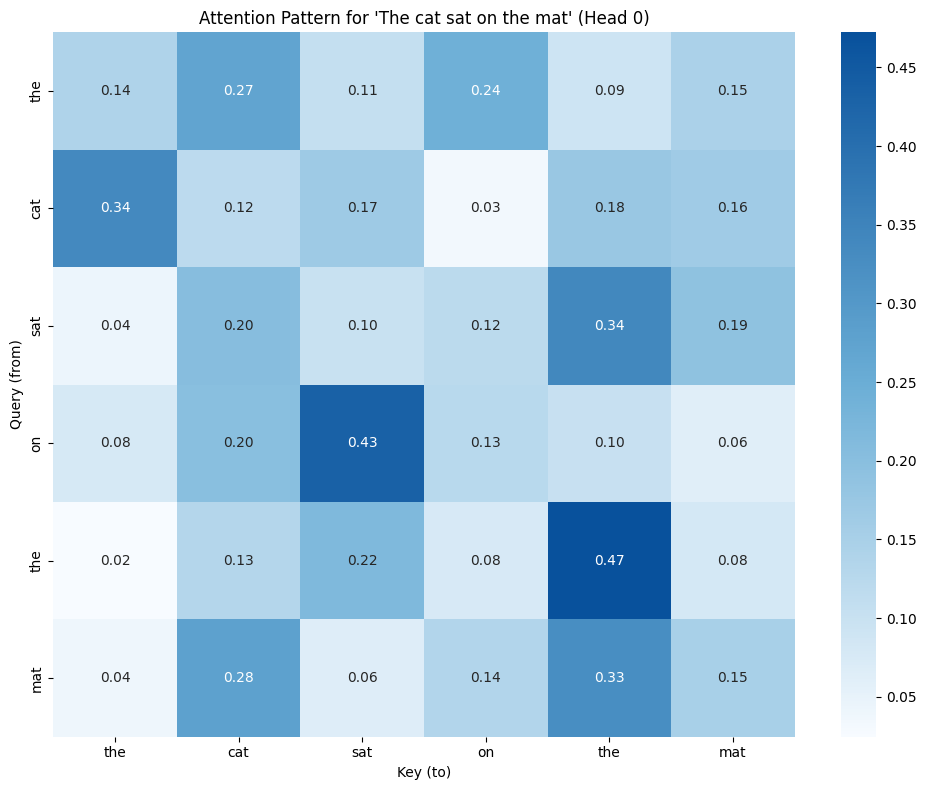

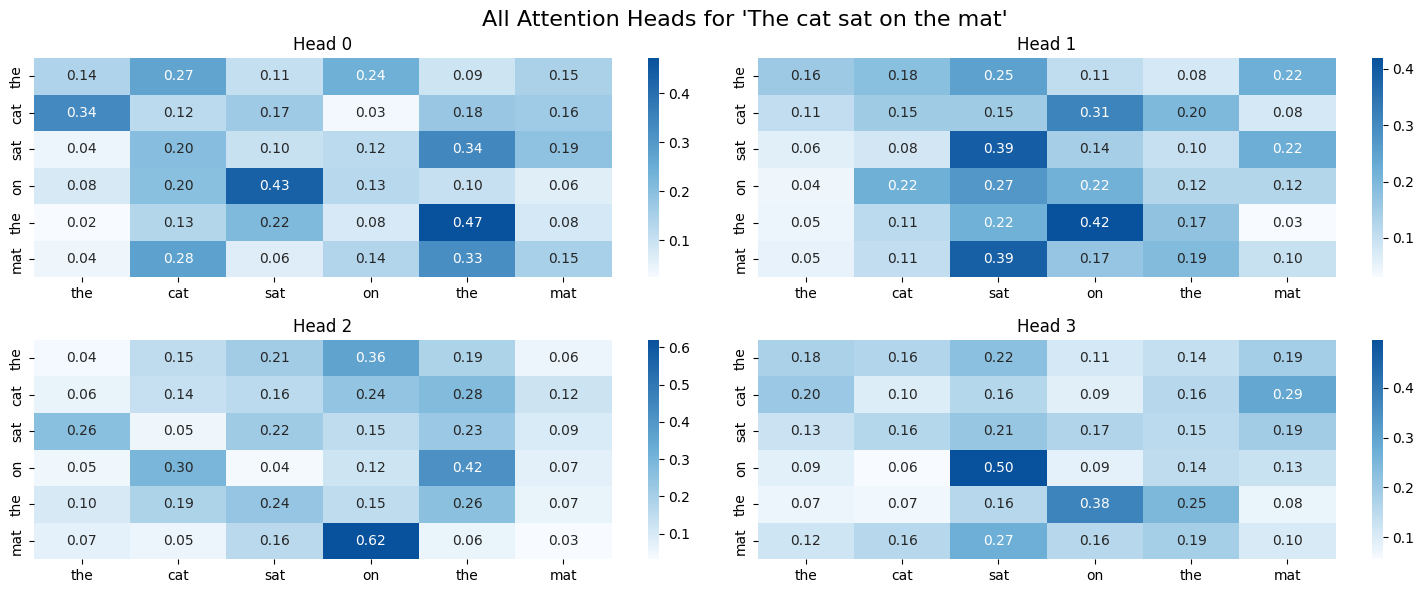

In [ ]:
# model params
d_model = 64
num_heads = 4

# self-attention layer
attention_layer = SelfAttention(d_model, num_heads)

# example one: simple sentence
sentence1 = "The cat sat on the mat"
tokens1, embeddings1 = prepare_input(sentence1, d_model)

# apply attention and get weights
_, attention_weights1 = attention_layer(embeddings1, return_attention=True)

# visualize attention for one head
visualize_attention(tokens1, attention_weights1, head_index=0,
                    title="Attention Pattern for 'The cat sat on the mat'")

# visualize all attention heads
visualize_all_heads(tokens1, attention_weights1,
                    title="All Attention Heads for 'The cat sat on the mat'")

## Analyzing different linguistic phenomena

Let's explore how attention captures different linguistic relationships by examining a few carefully chosen examples.

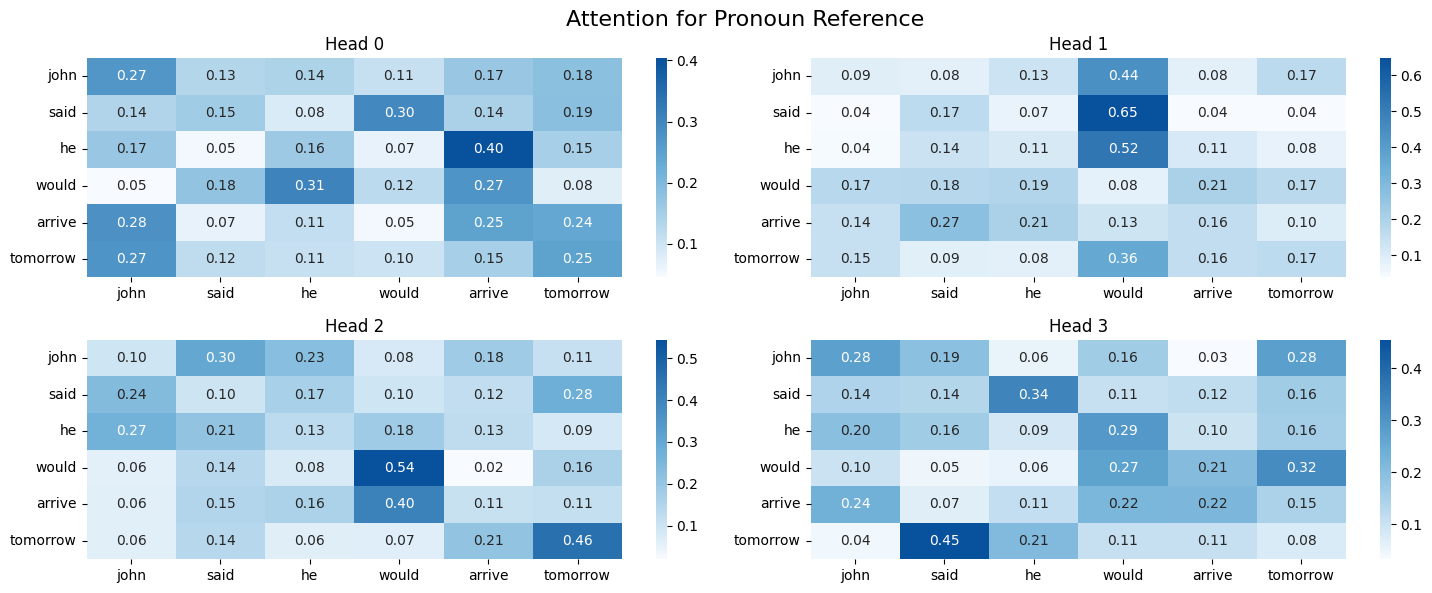

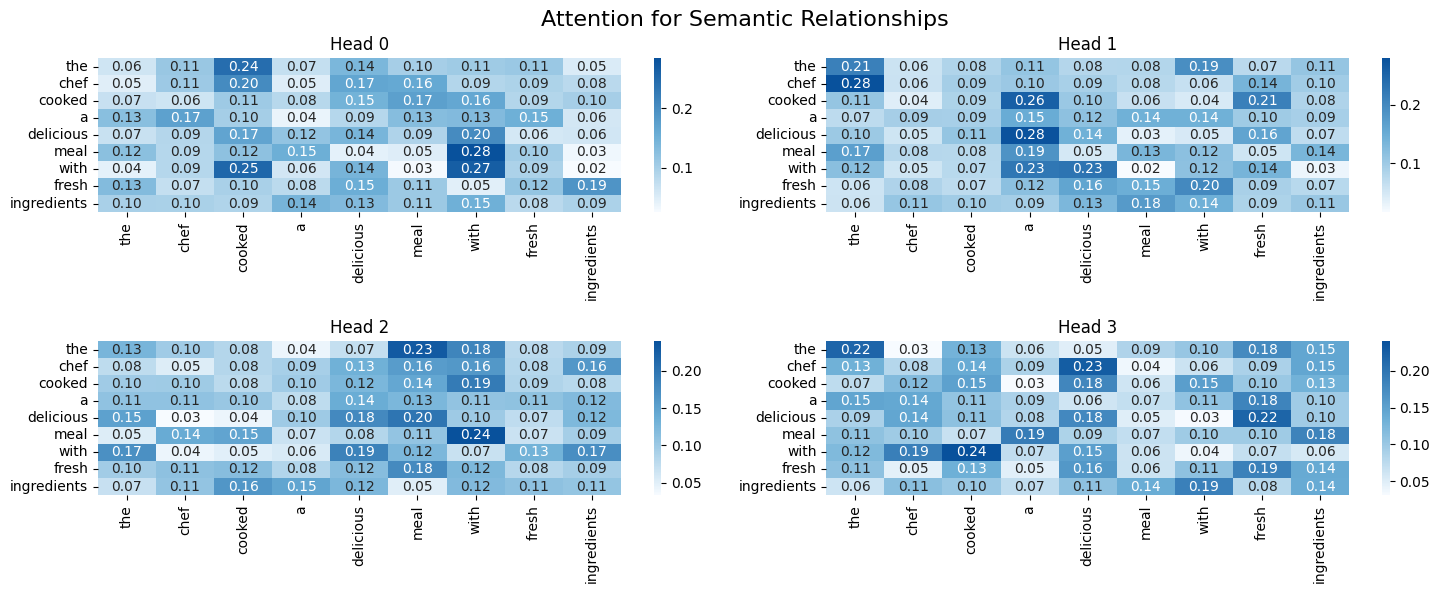

In [ ]:
# example two: sentence with pronoun reference
sentence2 = "John said he would arrive tomorrow"
tokens2, embeddings2 = prepare_input(sentence2, d_model)

# apply attention
_, attention_weights2 = attention_layer(embeddings2, return_attention=True)

# visualize
visualize_all_heads(tokens2, attention_weights2,
                   title="Attention for Pronoun Reference")

# example three: sentence with semantic relationships
sentence3 = "The chef cooked a delicious meal with fresh ingredients"
tokens3, embeddings3 = prepare_input(sentence3, d_model)

# apply attention
_, attention_weights3 = attention_layer(embeddings3, return_attention=True)

# visualize
visualize_all_heads(tokens3, attention_weights3,
                   title="Attention for Semantic Relationships")

## Exploring different attention patterns

Different types of attention patterns serve different purposes in transformer models. Let's implement and visualize some common patterns:

In [ ]:
def generate_attention_mask(length, pattern_type):
    """
    Generate attention masks for different patterns.

    Args:
        length: Sequence length
        pattern_type: Type of attention pattern
            - 'causal': Lower triangular (used in decoder self-attention)
            - 'local': Band diagonal (attends to nearby tokens only)
            - 'global-local': Combination of global tokens and local attention

    Returns:
        mask: Boolean mask where False indicates positions to attend to
    """
    if pattern_type == 'causal':
        # lower triangular mask (can't see future tokens)
        mask = 1 - np.tril(np.ones((1, length, length)))

    elif pattern_type == 'local':
        # band diagonal mask (can only see nearby tokens)
        window_size = max(1, length // 4)
        mask = np.ones((1, length, length))
        for i in range(length):
            start = max(0, i - window_size)
            end = min(length, i + window_size + 1)
            mask[0, i, start:end] = 0

    elif pattern_type == 'global-local':
        # first tokens are global, rest have local attention
        num_global = max(1, length // 5)
        mask = np.ones((1, length, length))

        # global tokens attend to all tokens
        mask[0, :num_global, :] = 0

        # all tokens attend to global tokens
        mask[0, :, :num_global] = 0

        # local attention for non-global tokens
        window_size = max(1, length // 4)
        for i in range(num_global, length):
            start = max(num_global, i - window_size)
            end = min(length, i + window_size + 1)
            mask[0, i, start:end] = 0

    else:
        # no mask (standard self-attention)
        mask = np.zeros((1, length, length))

    return tf.convert_to_tensor(mask, dtype=tf.float32)

def visualize_attention_pattern(pattern_type, sentence):
    """Visualize a specific attention pattern on a sentence"""
    tokens, embeddings = prepare_input(sentence, d_model)
    seq_len = embeddings.shape[1]

    # generate the appropriate mask
    mask = generate_attention_mask(seq_len, pattern_type)

    # apply attention with mask
    _, attention_weights = attention_layer(embeddings, mask=mask, return_attention=True)

    # visualize
    visualize_all_heads(tokens, attention_weights,
                       title=f"'{pattern_type}' Attention Pattern")

    # show the mask too
    plt.figure(figsize=(6, 5))
    plt.imshow(mask[0], cmap='binary')
    plt.colorbar()
    plt.title(f"'{pattern_type}' Attention Mask")
    plt.xticks(range(len(tokens)), tokens)
    plt.yticks(range(len(tokens)), tokens)
    plt.tight_layout()
    plt.show()

## Visualizing different attention patterns

Let's compare different attention patterns on the same sentence:

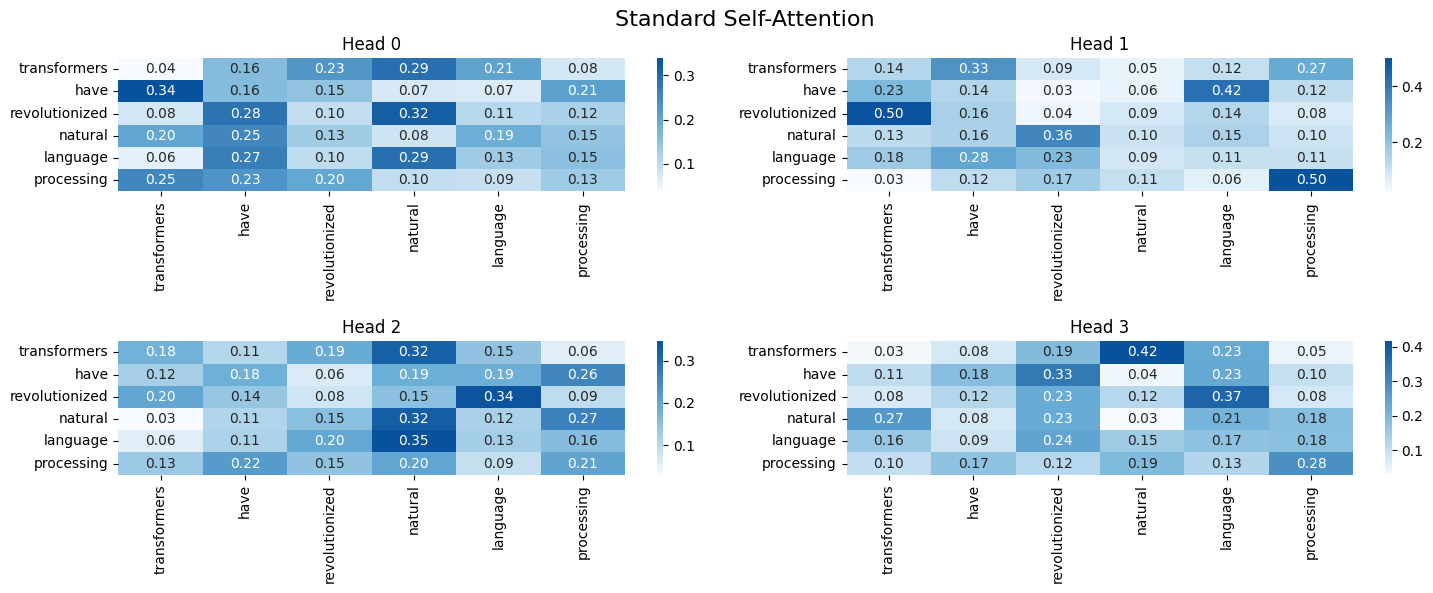

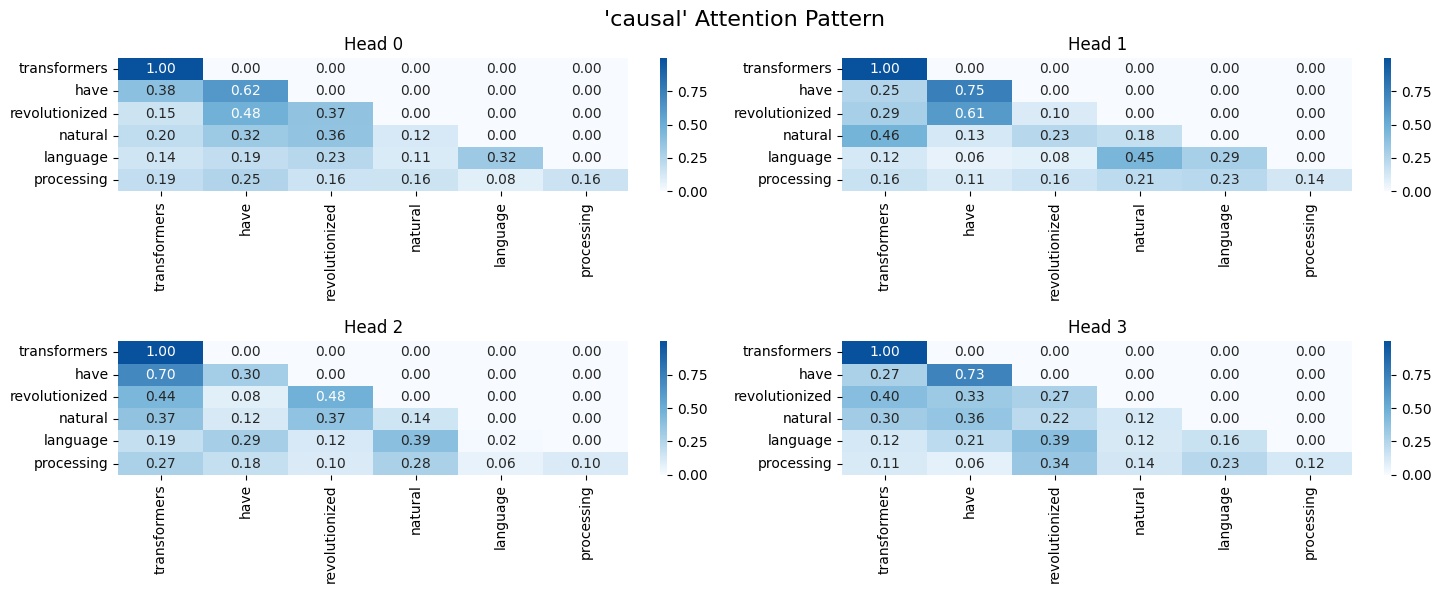

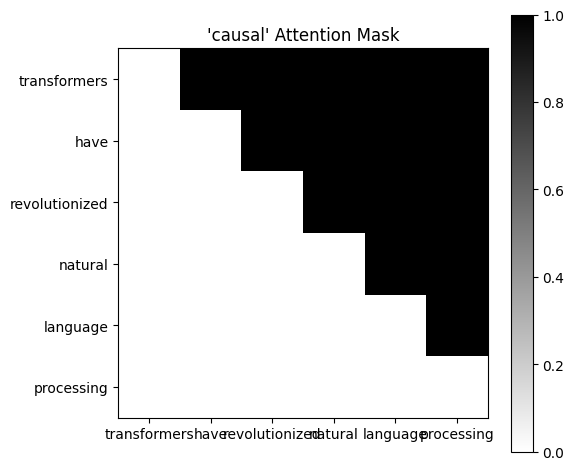

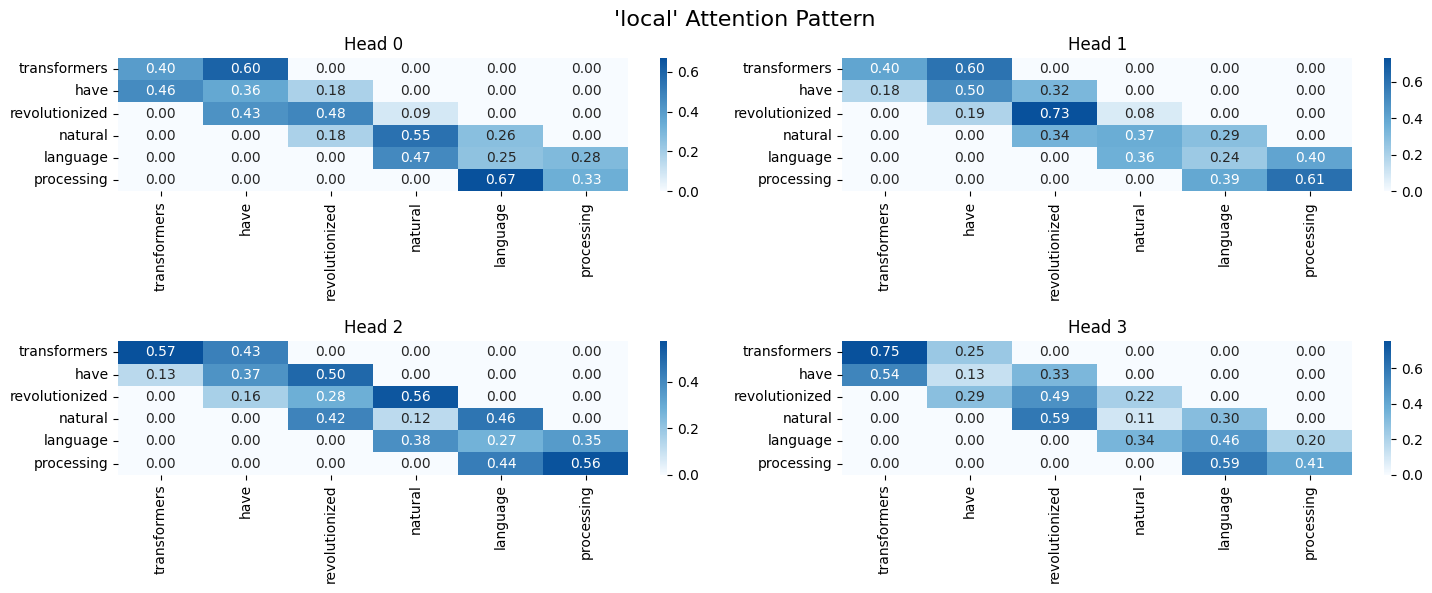

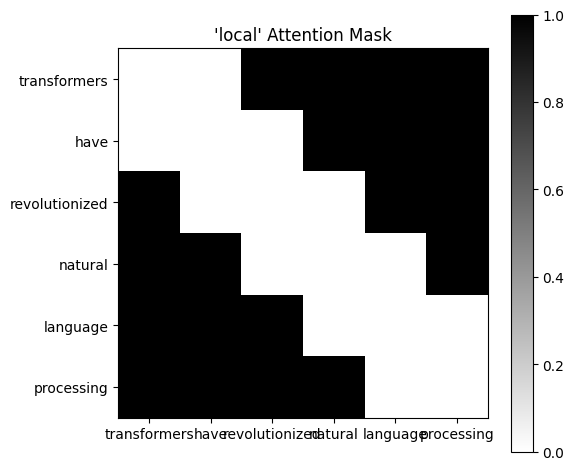

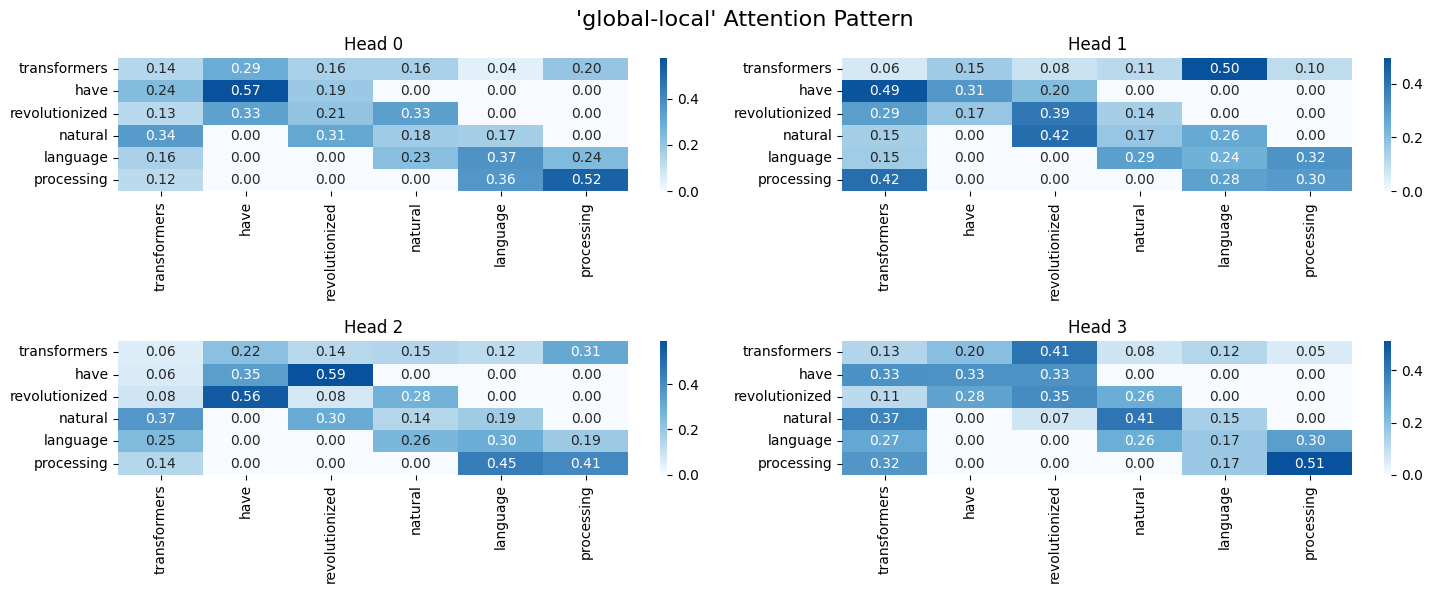

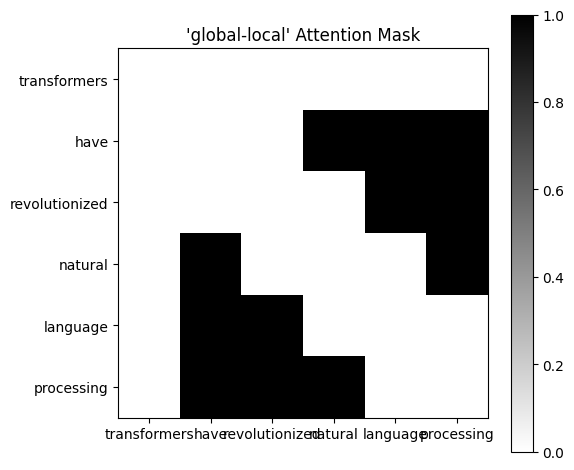

In [ ]:
sample_sentence = "Transformers have revolutionized natural language processing"

# standard attention (no mask)
_, embeddings = prepare_input(sample_sentence, d_model)
_, attention_weights = attention_layer(embeddings, return_attention=True)
tokens = preprocess_sentence(sample_sentence)
visualize_all_heads(tokens, attention_weights, title="Standard Self-Attention")

# causal attention (decoder-style)
visualize_attention_pattern('causal', sample_sentence)

# local attention
visualize_attention_pattern('local', sample_sentence)

# global-local attention
visualize_attention_pattern('global-local', sample_sentence)

## Comparing attention in different length sequences

Attention patterns can look different in sequences of different lengths. Let's compare:

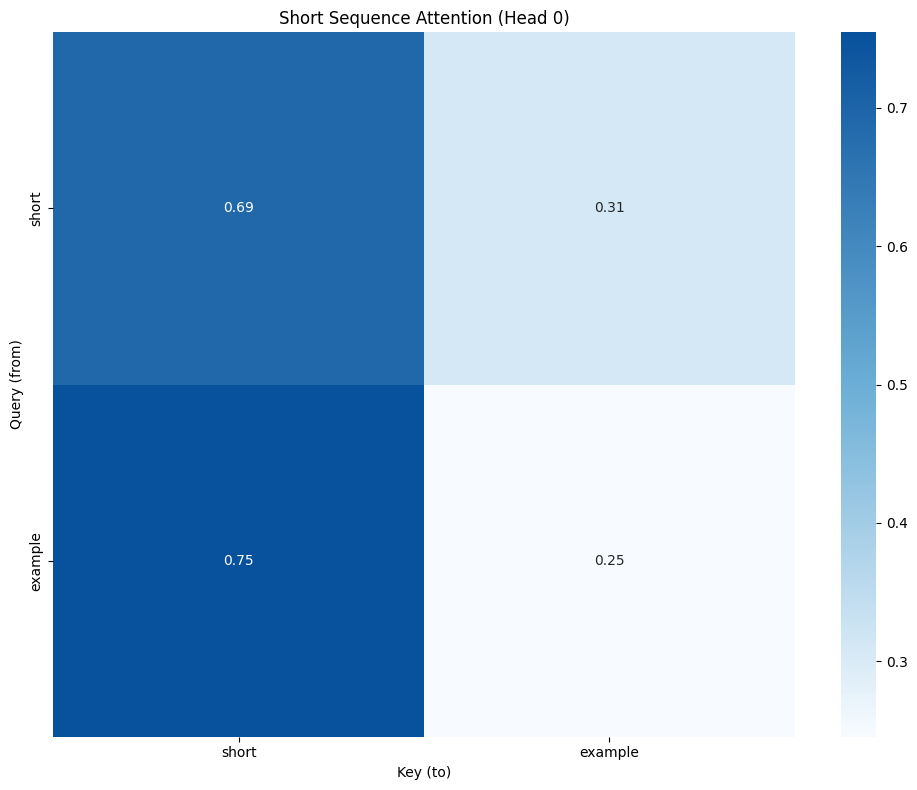

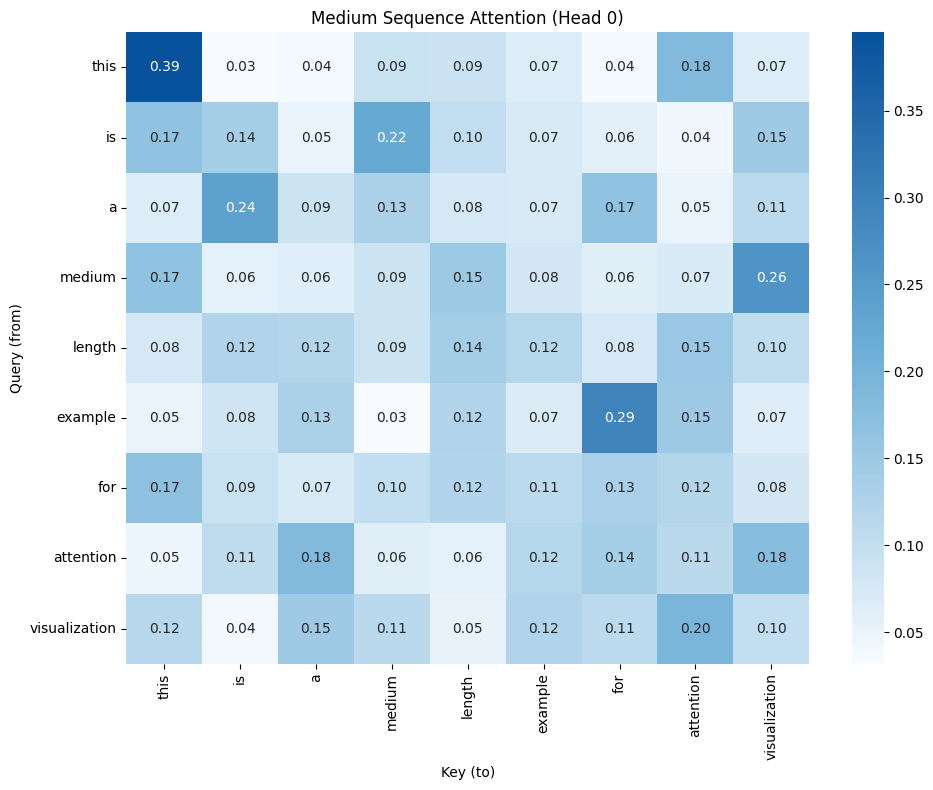

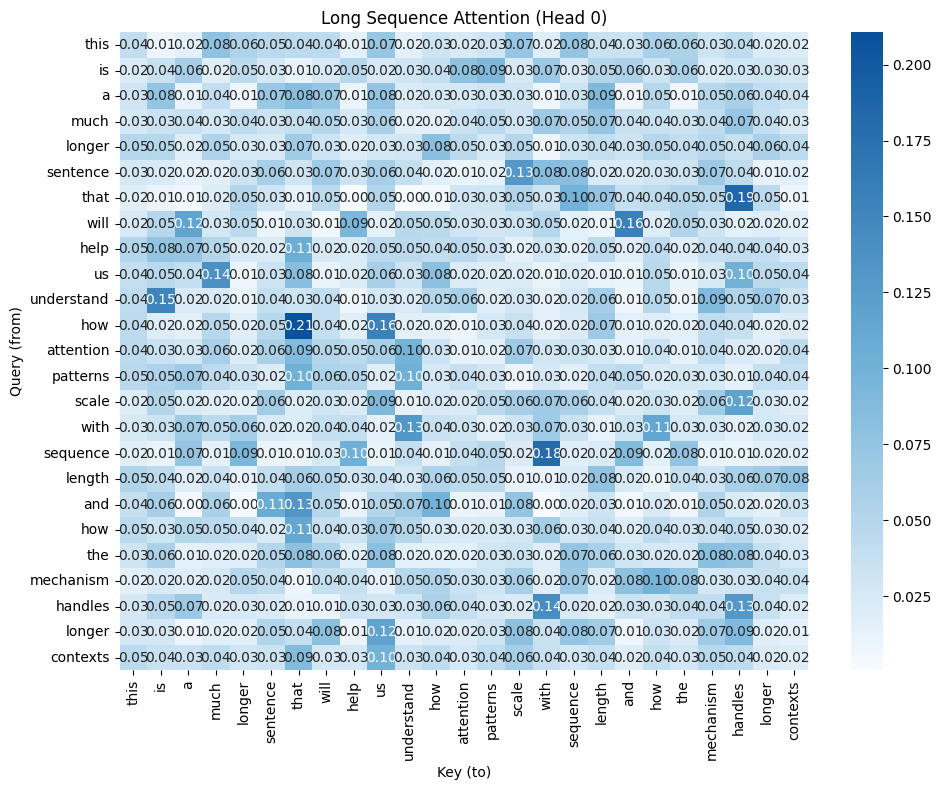

In [ ]:
short_sentence = "Short example"
medium_sentence = "This is a medium length example for attention visualization"
long_sentence = "This is a much longer sentence that will help us understand how attention patterns scale with sequence length and how the mechanism handles longer contexts"

sentences = [short_sentence, medium_sentence, long_sentence]
labels = ["Short", "Medium", "Long"]

for sentence, label in zip(sentences, labels):
    tokens, embeddings = prepare_input(sentence, d_model)
    _, attention_weights = attention_layer(embeddings, return_attention=True)

    # Just look at first head for simplicity
    visualize_attention(tokens, attention_weights, head_index=0,
                        title=f"{label} Sequence Attention")

## Interactive attention visualization

Let's create a function that lets us analyze attention on any input sentence:

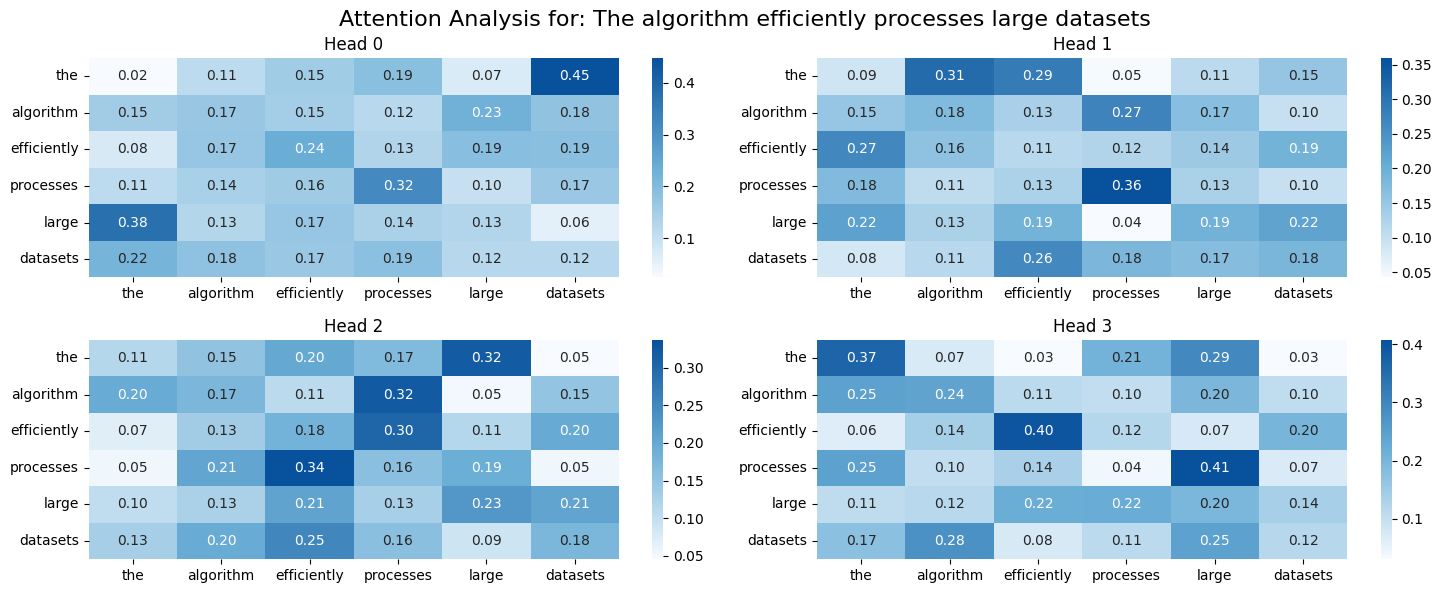

Most attended tokens:
  'the' → 'large' (attention: 0.20)
  'algorithm' → 'processes' (attention: 0.20)
  'efficiently' → 'efficiently' (attention: 0.23)
  'processes' → 'processes' (attention: 0.22)
  'large' → 'the' (attention: 0.20)
  'datasets' → 'algorithm' (attention: 0.19)


In [ ]:
def analyze_attention(sentence, pattern_type=None):
    """Analyze attention patterns for a given sentence"""
    tokens, embeddings = prepare_input(sentence, d_model)

    if pattern_type:
        mask = generate_attention_mask(len(tokens), pattern_type)
        _, attention_weights = attention_layer(embeddings, mask=mask, return_attention=True)
        title = f"'{pattern_type}' Attention for: {sentence}"
    else:
        _, attention_weights = attention_layer(embeddings, return_attention=True)
        title = f"Attention Analysis for: {sentence}"

    visualize_all_heads(tokens, attention_weights, title=title)

    # avg attention across heads
    avg_attention = tf.reduce_mean(attention_weights, axis=1).numpy()[0]

    # most attended token for each position
    most_attended_indices = np.argmax(avg_attention, axis=1)

    print("Most attended tokens:")
    for i, token in enumerate(tokens):
        attended_token = tokens[most_attended_indices[i]]
        print(f"  '{token}' → '{attended_token}' (attention: {avg_attention[i, most_attended_indices[i]]:.2f})")

# test with a custom sentence
custom_sentence = "The algorithm efficiently processes large datasets"
analyze_attention(custom_sentence)

## Conclusion

In this notebook, we've implemented and visualized the attention mechanism at the core of transformer models from Andrej Karpathy's "Neural Networks: Zero to Hero" course. We've seen:

1. How self-attention works mathematically with queries, keys, and values
2. How different attention heads can focus on different aspects of the input
3. Different attention patterns like causal (for autoregressive models), local, and global-local
4. How sequence length affects attention distributions

Understanding attention is crucial for understanding modern NLP models like GPT and BERT, and visualizing it helps build intuition about how these models process language.

This implementation is simplified for practice purposes - production models will likely include additional components like positional encoding, layer normalization, and feed-forward networks.

## Bonus: Attention & Positional Information

One limitation of the basic attention mechanism is that it doesn't inherently understand the position of tokens. Let's briefly demonstrate this and show how positional encoding helps:

In [ ]:
def add_simple_positional_encoding(embeddings):
    """Add simple positional encoding to the embeddings"""
    batch_size, seq_len, d_model = embeddings.shape
    positions = np.arange(seq_len)[:, np.newaxis]

    # simple encoding based on sine/cosine functions with different frequencies
    div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

    pos_encoding = np.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = np.sin(positions * div_term)
    pos_encoding[:, 1::2] = np.cos(positions * div_term)

    # add positional encoding to the embeddings
    result = embeddings + tf.convert_to_tensor(pos_encoding[np.newaxis, :, :], dtype=tf.float32)
    return result

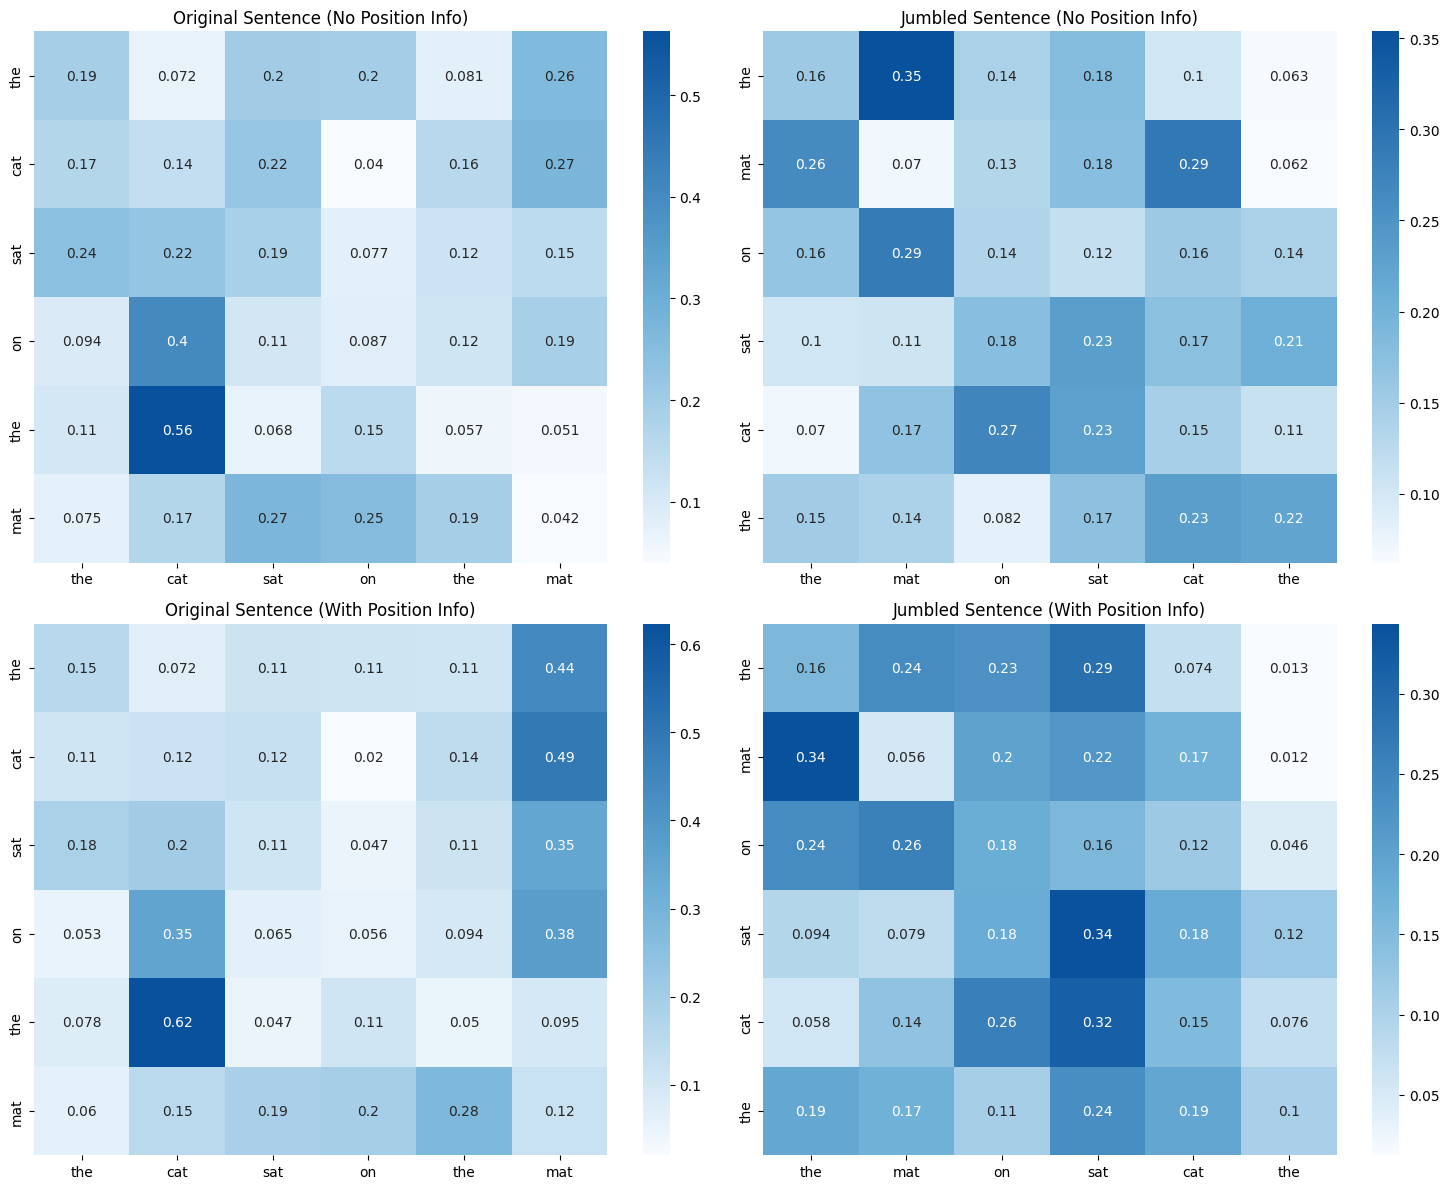

Notice how positional encoding changes the attention patterns!
Without position information, attention is based purely on token similarity.
With position information, the model can learn patterns related to sequence order.


In [ ]:
# illustrate with the same sentence in different word orders
original = "the cat sat on the mat"
jumbled = "the mat on sat cat the"

# process both without positional encoding
tokens_orig, embed_orig = prepare_input(original, d_model)
tokens_jumbled, embed_jumbled = prepare_input(jumbled, d_model)

_, attn_orig = attention_layer(embed_orig, return_attention=True)
_, attn_jumbled = attention_layer(embed_jumbled, return_attention=True)

# process both WITH positional encoding
embed_orig_pos = add_simple_positional_encoding(embed_orig)
embed_jumbled_pos = add_simple_positional_encoding(embed_jumbled)

_, attn_orig_pos = attention_layer(embed_orig_pos, return_attention=True)
_, attn_jumbled_pos = attention_layer(embed_jumbled_pos, return_attention=True)

# visualize
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
sns.heatmap(attn_orig[0, 0].numpy(), annot=True, cmap=attention_colors,
            xticklabels=tokens_orig, yticklabels=tokens_orig)
plt.title("Original Sentence (No Position Info)")

plt.subplot(2, 2, 2)
sns.heatmap(attn_jumbled[0, 0].numpy(), annot=True, cmap=attention_colors,
            xticklabels=tokens_jumbled, yticklabels=tokens_jumbled)
plt.title("Jumbled Sentence (No Position Info)")

plt.subplot(2, 2, 3)
sns.heatmap(attn_orig_pos[0, 0].numpy(), annot=True, cmap=attention_colors,
            xticklabels=tokens_orig, yticklabels=tokens_orig)
plt.title("Original Sentence (With Position Info)")

plt.subplot(2, 2, 4)
sns.heatmap(attn_jumbled_pos[0, 0].numpy(), annot=True, cmap=attention_colors,
            xticklabels=tokens_jumbled, yticklabels=tokens_jumbled)
plt.title("Jumbled Sentence (With Position Info)")

plt.tight_layout()
plt.show()

print("Positional encoding changes the attention patterns!")
print("Without position information, attention is based purely on token similarity.")
print("With position information, the model can learn patterns related to sequence order.")